# Interpreting Bias in Static Word Embeddings with WEAT

In [23]:
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.downloader import load

In [12]:
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

vectors = load('word2vec-google-news-300')

In [ ]:
extreme_she_occupations = [
    "homemaker", "nurse", "receptionist",
    "librarian", "socialite", "hairdresser",
    "nanny", "bookkeeper", "stylist",
    "housekeeper", "interior designer", "guidance counselor"
]

extreme_he_occupations = [
    "maestro", "skipper", "protege",
    "philosopher", "captain", "architect",
    "financier", "warrior", "broadcaster",
    "magician", "fighter pilot", "boss"
]


attribute1 = ["he", "him", "his", "man", "male"]
attribute2 = ["she", "her", "hers", "woman", "female"]

def filter_vocab(words):
    return [w for w in words if w in vectors]

target1 = filter_vocab(extreme_she_occupations)
target2 = filter_vocab(extreme_he_occupations)
attribute1 = filter_vocab(attribute1)
attribute2 = filter_vocab(attribute2)

In [ ]:
def association(w, A, B):
    return np.mean([vectors.similarity(w, a) for a in A]) - np.mean([vectors.similarity(w, b) for b in B])

def weat_effect_size(X, Y, A, B):
    s_X = [association(x, A, B) for x in X]
    s_Y = [association(y, A, B) for y in Y]
    return (np.mean(s_X) - np.mean(s_Y)) / np.std(s_X + s_Y)

effect_size = weat_effect_size(target1, target2, attribute1, attribute2)
print(f"WEAT Effect Size: {effect_size:.3f}")

WEAT Effect Size: -1.973


In [ ]:
def permutation_test(X, Y, A, B, num_samples=10000):
    XY = X + Y
    observed = weat_effect_size(X, Y, A, B)
    more_extreme = 0

    for _ in range(num_samples):
        np.random.shuffle(XY)
        X_i = XY[:len(X)]
        Y_i = XY[len(X):]
        stat = weat_effect_size(X_i, Y_i, A, B)
        if abs(stat) >= abs(observed):
            more_extreme += 1

    return observed, more_extreme / num_samples

observed, p_value = permutation_test(target1, target2, attribute1, attribute2)
print(f"Observed Effect Size: {observed:.3f}")
print(f"P-value (Permutation Test): {p_value:.4f}")

Observed Effect Size: -1.973
P-value (Permutation Test): 0.0000


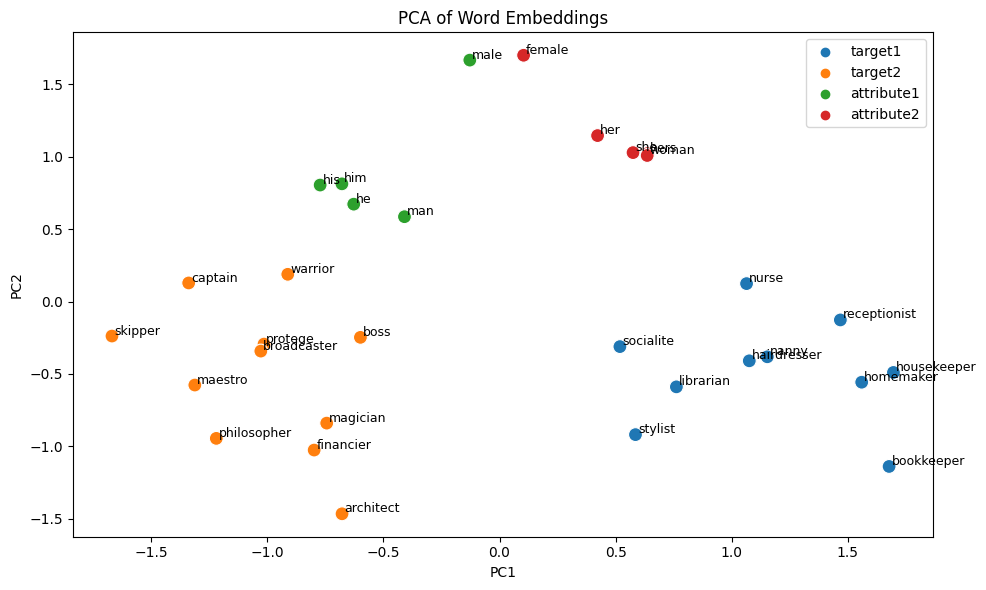

In [ ]:
all_words = target1 + target2 + attribute1 + attribute2
vectors = [vectors[w] for w in all_words]
labels = all_words
categories = (["target1"] * len(target1) + ["target2"] * len(target2) +
              ["attribute1"] * len(attribute1) + ["attribute2"] * len(attribute2))

pca = PCA(n_components=2)
points = pca.fit_transform(vectors)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=points[:, 0], y=points[:, 1], hue=categories, s=100)

for i, label in enumerate(labels):
    plt.text(points[i, 0]+0.01, points[i, 1]+0.01, label, fontsize=9)

plt.title("PCA of Word Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

### Biased analogies analysis

In [ ]:
model = api.load('word2vec-google-news-300')

def solve_analogy(model, word_a, word_b, word_c, n_results=5, exclude_inputs=False):
    """
    Solve analogy: word_a is to word_b as word_c is to ?
    Returns top n_results candidates with similarity scores
    
    Method: vector(word_b) - vector(word_a) + vector(word_c) ≈ vector(word_d)
    
    Example: man is to king as woman is to ?
    Expected: queen
    """
    results = model.most_similar(
        positive=[word_b, word_c],
        negative=[word_a],
        topn=n_results + (3 if exclude_inputs else 0)  
    )
    
    if exclude_inputs:
        filtered_results = [
            (word, score) for word, score in results
            if word not in {word_a, word_b, word_c}
        ]
        return filtered_results[:n_results]
    else:
        return results[:n_results]

In [ ]:
def get_analogies(test_cases):
    results = []
    
    for male_term, profession, female_term in test_cases:
        print(f"\nAnalogy: {male_term} is to {profession} as {female_term} is to ?")
        
        candidates = solve_analogy(model, male_term, profession, female_term, n_results=5)    
        
        print(f"Top predictions:")
        for i, (word, score) in enumerate(candidates[:5], 1):
            print(f"  {i}. {word} (similarity: {score:.4f})")
        
        result_entry = {
            'male_term': male_term,
            'profession': profession,
            'female_term': female_term,
            'top_prediction': candidates[0][0],
            'top_score': candidates[0][1],
            'all_predictions': [word for word, _ in candidates[:5]]
        }
        results.append(result_entry)
    return results

In [34]:
gender_profession_tests = [
    # Leadership roles
    ("man", "CEO", "woman"),
    ("man", "president", "woman"),
    ("man", "manager", "woman"),
    ("man", "boss", "woman"),
    ("man", "leader", "woman"),
    
    # STEM fields
    ("man", "scientist", "woman"),
    ("man", "programmer", "woman"),
    ("man", "researcher", "woman"),
    ("man", "professor", "woman"),
    ("man", "architect", "woman"),
    
    # Care/service professions
    ("woman", "nurse", "man"),
    ("woman", "teacher", "man"),
    ("woman", "secretary", "man"),
    ("woman", "therapist", "man"),
    
    # Manual labor/trades
    ("man", "mechanic", "woman"),
    ("man", "electrician", "woman"),
    ("man", "carpenter", "woman"),
    ("man", "plumber", "woman"),
]
    
print(get_analogies(gender_profession_tests))


Analogy: man is to CEO as woman is to ?
Top predictions:
  1. COO (similarity: 0.7113)
  2. Chief_Executive_Officer (similarity: 0.7084)
  3. chief_executive (similarity: 0.7022)
  4. Chief_Operating_Officer (similarity: 0.6757)
  5. Chief_Executive (similarity: 0.6722)

Analogy: man is to president as woman is to ?
Top predictions:
  1. President (similarity: 0.6533)
  2. chairwoman (similarity: 0.5765)
  3. vice_president (similarity: 0.5682)
  4. chairperson (similarity: 0.5559)
  5. Vice_President (similarity: 0.5502)

Analogy: man is to manager as woman is to ?
Top predictions:
  1. vice_president (similarity: 0.6235)
  2. director (similarity: 0.6135)
  3. manger (similarity: 0.5982)
  4. supervisor (similarity: 0.5697)
  5. vp (similarity: 0.5604)

Analogy: man is to boss as woman is to ?
Top predictions:
  1. bosses (similarity: 0.5523)
  2. manageress (similarity: 0.4915)
  3. exec (similarity: 0.4594)
  4. Manageress (similarity: 0.4560)
  5. receptionist (similarity: 0.4474

In [35]:
personality_bias_tests = [
    # Leadership qualities
    ("man", "assertive", "woman"),
    ("man", "aggressive", "woman"),
    ("man", "confident", "woman"),
    ("man", "ambitious", "woman"),
    ("man", "competitive", "woman"),
    
    # Emotional traits
    ("woman", "emotional", "man"),
    ("woman", "nurturing", "man"),
    ("woman", "caring", "man"),
    ("woman", "sensitive", "man"),
    ("woman", "empathetic", "man"),
    
    # Intelligence/competence
    ("man", "brilliant", "woman"),
    ("man", "genius", "woman"),
    ("man", "expert", "woman"),
    ("man", "logical", "woman"),
    ("man", "rational", "woman"),
]

print(get_analogies(personality_bias_tests))


Analogy: man is to assertive as woman is to ?
Top predictions:
  1. assertiveness (similarity: 0.5358)
  2. submissive (similarity: 0.4990)
  3. forceful (similarity: 0.4945)
  4. assertively (similarity: 0.4918)
  5. aggressive (similarity: 0.4783)

Analogy: man is to aggressive as woman is to ?
Top predictions:
  1. agressive (similarity: 0.6350)
  2. aggresive (similarity: 0.5804)
  3. overly_aggressive (similarity: 0.5761)
  4. assertive (similarity: 0.5274)
  5. aggressively (similarity: 0.5222)

Analogy: man is to confident as woman is to ?
Top predictions:
  1. optimistic (similarity: 0.6182)
  2. hopeful (similarity: 0.6055)
  3. cautiously_optimistic (similarity: 0.5902)
  4. guardedly_optimistic (similarity: 0.5305)
  5. convinced (similarity: 0.5045)

Analogy: man is to ambitious as woman is to ?
Top predictions:
  1. Ambitious (similarity: 0.5606)
  2. black_sequined_bras (similarity: 0.5444)
  3. swifter_glossier (similarity: 0.5422)
  4. local_teen_determ (similarity: 0.

In [36]:
appearance_bias_tests = [
    ("man", "handsome", "woman"),
    ("woman", "beautiful", "man"),
    ("man", "attractive", "woman"),
    ("man", "beautiful", "woman"),
    ("man", "fit", "woman"),
]
print(get_analogies(appearance_bias_tests))


Analogy: man is to handsome as woman is to ?
Top predictions:
  1. shapely (similarity: 0.5565)
  2. comely (similarity: 0.5341)
  3. bosomy (similarity: 0.5241)
  4. curvacious (similarity: 0.5179)
  5. brunet (similarity: 0.5171)

Analogy: woman is to beautiful as man is to ?
Top predictions:
  1. gorgeous (similarity: 0.6688)
  2. lovely (similarity: 0.6598)
  3. magnificent (similarity: 0.6556)
  4. wonderful (similarity: 0.5891)
  5. majestic (similarity: 0.5871)

Analogy: man is to attractive as woman is to ?
Top predictions:
  1. unattractive (similarity: 0.6347)
  2. alluring (similarity: 0.6146)
  3. desirable (similarity: 0.5546)
  4. Attractive (similarity: 0.5133)
  5. attractive_proposition (similarity: 0.4957)

Analogy: man is to beautiful as woman is to ?
Top predictions:
  1. gorgeous (similarity: 0.7102)
  2. lovely (similarity: 0.6797)
  3. breathtakingly_beautiful (similarity: 0.6789)
  4. stunningly_beautiful (similarity: 0.6787)
  5. strikingly_beautiful (similari